In [4]:
# !pip install tensorflow==2.10.0 tensorflow_hub==0.12.0 tensorflow_text==2.10.0

In [5]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd

In [6]:
df = pd.read_csv("/content/spam.csv")
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
df.groupby("Category").describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [8]:
df["Category"].value_counts()

,count
Category,
ham,4825
spam,747


In [9]:
df_spam = df[df["Category"] == "spam"]
df_spam.shape

(747, 2)

In [10]:
df_ham = df[df["Category"] == "ham"]
df_ham.shape

(4825, 2)

In [11]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 2)

In [12]:
df_balanced = pd.concat([df_ham_downsampled , df_spam])
df_balanced.shape

(1494, 2)

In [13]:
df_balanced["Category"].value_counts()

,count
Category,
ham,747
spam,747


In [14]:
df_balanced["spam"] = df["Category"].apply(lambda x : 1 if x == "spam" else 0)
df_balanced.sample(5)

,Category,Message,spam
4643,spam,You are being ripped off! Get your mobile cont...,1
3382,spam,"complimentary 4 STAR Ibiza Holiday or £10,000 ...",1
4864,spam,Bored housewives! Chat n date now! 0871750.77....,1
3494,ham,"Cool, text me when you head out",0
2300,spam,Congrats! 1 year special cinema pass for 2 is ...,1


In [15]:
from sklearn.model_selection import train_test_split

X_train , X_test , y_train , y_test = train_test_split(df_balanced["Message"] , df_balanced["spam"] , test_size = 0.2 ,
                                                       random_state=0 , stratify = df_balanced["spam"])


In [16]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [17]:
def get_sentence_embeding(sentences):
  prepprocess_text = bert_preprocess(sentences)
  return bert_encoder(prepprocess_text)["pooled_output"]

get_sentence_embeding(["Hi this is hamza","Are you a student"])

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.88264555, -0.4484348 , -0.5818956 , ..., -0.3355283 ,
        -0.69695884,  0.92008865],
       [-0.85056674, -0.23816264,  0.02395771, ...,  0.05872614,
        -0.546572  ,  0.86376745]], dtype=float32)>

In [18]:
e = get_sentence_embeding([
    "banana",
    "grapes",
    "mango",
    "jeff bezos",
    "elon musk",
    "bill gates"
])

In [19]:
e

<tf.Tensor: shape=(6, 768), dtype=float32, numpy=
array([[-0.7606917 , -0.1421937 ,  0.49604657, ...,  0.4216535 ,
        -0.53221387,  0.8031217 ],
       [-0.86023223, -0.21242924,  0.49156895, ...,  0.39798045,
        -0.60506284,  0.8447166 ],
       [-0.7128861 , -0.15463921,  0.38401648, ...,  0.3527873 ,
        -0.5099134 ,  0.734741  ],
       [-0.82533467, -0.35550576, -0.590697  , ..., -0.01613736,
        -0.6141759 ,  0.8723029 ],
       [-0.75041336, -0.26812622, -0.2668967 , ...,  0.02839388,
        -0.5938097 ,  0.7974987 ],
       [-0.7854443 , -0.2994975 ,  0.41027164, ...,  0.522253  ,
        -0.49573603,  0.81507564]], dtype=float32)>

In [20]:

from sklearn.metrics.pairwise import cosine_similarity

cosine_similarity([e[4],e[3]])

array([[0.9999999 , 0.98720324],
       [0.98720324, 1.        ]], dtype=float32)

In [21]:
### Functional Model
# Bert Layers
text_input = tf.keras.layers.Input(shape=() , dtype=tf.string , name="text")
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural Network Layers
l = tf.keras.layers.Dropout(0.1 , name="dropout")(outputs["pooled_output"])
l = tf.keras.layers.Dense(1,activation="sigmoid", name="output")(l)


#Construct final model
model = tf.keras.Model(inputs=[text_input] , outputs = [l])


In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [23]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name="accuracy"),
    tf.keras.metrics.Precision(name="precision"),
    tf.keras.metrics.Recall(name="recall")
]

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=METRICS
)

In [26]:
model.fit(X_train , y_train , epochs=1)

38/38 [==============================] - 363s 10s/step - loss: 0.5615 - accuracy: 0.7556 - precision: 0.7508 - recall: 0.7659


In [27]:
model.evaluate(X_test, y_test)

10/10 [==============================] - 92s 9s/step - loss: 0.4980 - accuracy: 0.8328 - precision: 0.7705 - recall: 0.9463


[0.4980185925960541, 0.832775890827179, 0.7704917788505554, 0.9463087320327759]

In [28]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

10/10 [==============================] - 93s 9s/step


In [29]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5 , 1 , 0)
y_predicted

array([0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1])

In [31]:
from sklearn.metrics import confusion_matrix , classification_report

cm = confusion_matrix(y_test , y_predicted)
cm

array([[108,  42],
       [  8, 141]])

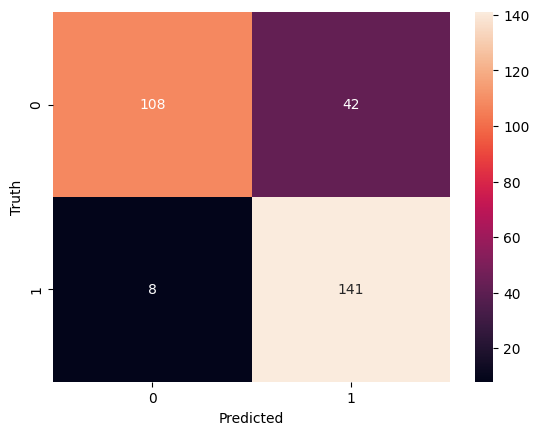

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.heatmap(cm , annot=True , fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Truth")
plt.show()

In [34]:
print(classification_report(y_test , y_predicted))

              precision    recall  f1-score   support

           0       0.93      0.72      0.81       150
           1       0.77      0.95      0.85       149

    accuracy                           0.83       299
   macro avg       0.85      0.83      0.83       299
weighted avg       0.85      0.83      0.83       299

